# Import Modules

In [1]:
%load_ext autoreload
%autoreload 2

import os
import argparse
import glob
import sys 
import yaml 
import glob
import h5py 
import ray
import logging 
import json
import gc
import cv2
import time
import itertools

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
# import io_dict_to_hdf5 as ioh5
import xarray as xr
import scipy.linalg as linalg
import scipy.sparse as sparse
import matplotlib.gridspec as gridspec

from tqdm.notebook import tqdm
from matplotlib.backends.backend_pdf import PdfPages
from scipy import signal
from pathlib import Path
from scipy.optimize import minimize_scalar,minimize
from scipy.interpolate import interp1d
from scipy.ndimage import shift as imshift
from sklearn.model_selection import train_test_split, GroupShuffleSplit
from sklearn.pipeline import make_pipeline
from sklearn import linear_model as lm 
from scipy.stats import binned_statistic
from sklearn.utils import shuffle
from sklearn.metrics import r2_score, mean_poisson_deviance
from ray.actor import ActorHandle

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, TensorDataset, Subset
torch.backends.cudnn.benchmark = True
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

sys.path.append(str(Path('.').absolute()))
from utils import *
import io_dict_to_hdf5 as ioh5
from format_data import *

pd.set_option('display.max_rows', None)

ray.init(
    ignore_reinit_error=True,
    logging_level=logging.ERROR,
)


{'node_ip_address': '184.171.84.86',
 'raylet_ip_address': '184.171.84.86',
 'redis_address': '184.171.84.86:6379',
 'object_store_address': '/tmp/ray/session_2021-10-29_15-04-51_710814_1053375/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2021-10-29_15-04-51_710814_1053375/sockets/raylet',
 'webui_url': '127.0.0.1:8265',
 'session_dir': '/tmp/ray/session_2021-10-29_15-04-51_710814_1053375',
 'metrics_export_port': 49146,
 'node_id': '923eb8735417e555fdef29dc2f942b03f7a40ddc953d34643e347c2a'}

# Gather Data

In [2]:
free_move = True
if free_move:
    stim_type = 'fm1'
else:
    stim_type = 'hf1_wn' # 'fm1' # 
# 012821/EE8P6LT
# 128: 070921/J553RT
date_ani = '070921/J553RT' #'062921/G6HCK1ALTRN' '102621/J558NC'
date_ani2 = '_'.join(date_ani.split('/'))
data_dir  = Path('~/Goeppert/freely_moving_ephys/ephys_recordings/').expanduser() / date_ani / stim_type
save_dir  = check_path(Path('~/Research/SensoryMotorPred_Data/data/').expanduser() / date_ani, stim_type)
FigPath = check_path(Path('~/Research/SensoryMotorPred_Data').expanduser(),'Figures/Encoding')
FigPath = check_path(FigPath/date_ani, stim_type)

print('savd_dir:',save_dir)
print('data_dir:',data_dir)
print('FigPath:', FigPath)
# with open(save_dir / 'file_dict.json','r') as fp:
#     file_dict = json.load(fp)

savd_dir: /home/seuss/Research/SensoryMotorPred_Data/data/070921/J553RT/fm1
data_dir: /home/seuss/Goeppert/freely_moving_ephys/ephys_recordings/070921/J553RT/fm1
FigPath: /home/seuss/Research/SensoryMotorPred_Data/Figures/Encoding/070921/J553RT/fm1


In [3]:
file_dict = {'cell': 0,
            'drop_slow_frames': True,
            'ephys': list(data_dir.glob('*ephys_merge.json'))[0].as_posix(),
            'ephys_bin': list(data_dir.glob('*Ephys.bin'))[0].as_posix(),
            'eye': list(data_dir.glob('*REYE.nc'))[0].as_posix(),
            'imu': list(data_dir.glob('*imu.nc'))[0].as_posix() if stim_type=='fm1' else None,
            'mapping_json': '/home/seuss/Research/Github/FreelyMovingEphys/probes/channel_maps.json',
            'mp4': True,
            'name': date_ani2 + '_control_Rig2_'+stim_type, #070921_J553RT
            'probe_name': 'DB_P128-6',
            'save': data_dir.as_posix(),
            'speed': list(data_dir.glob('*speed.nc'))[0].as_posix() if stim_type=='hf1_wn' else None,
            'stim_type': 'light',
            'top': list(data_dir.glob('*TOP1.nc'))[0].as_posix() if stim_type=='fm1' else None,
            'world': list(data_dir.glob('*world.nc'))[0].as_posix(),}

In [4]:
model_dt = .05
do_shuffle=False
do_norm = False
data,train_idx,test_idx = load_train_test(file_dict, save_dir, model_dt=model_dt, do_shuffle=do_shuffle, do_norm=do_norm,free_move=free_move, has_imu=free_move, has_mouse=False, do_worldcam_correction=False)
locals().update(data)

lag_list = np.array([-2,-1,0,1,2]) #np.array([-1,0,1,2,3]) #,np.arange(minlag,maxlag,np.floor((maxlag-minlag)/nt_glm_lag).astype(int))
nt_glm_lag = len(lag_list)
print(lag_list,1000*lag_list*model_dt)
do_shuffle=False
model_type = 'Pytorch'

Done Loading Aligned Data
TRAIN: 15628 TEST: 6698
[-2 -1  0  1  2] [-100.  -50.    0.   50.  100.]


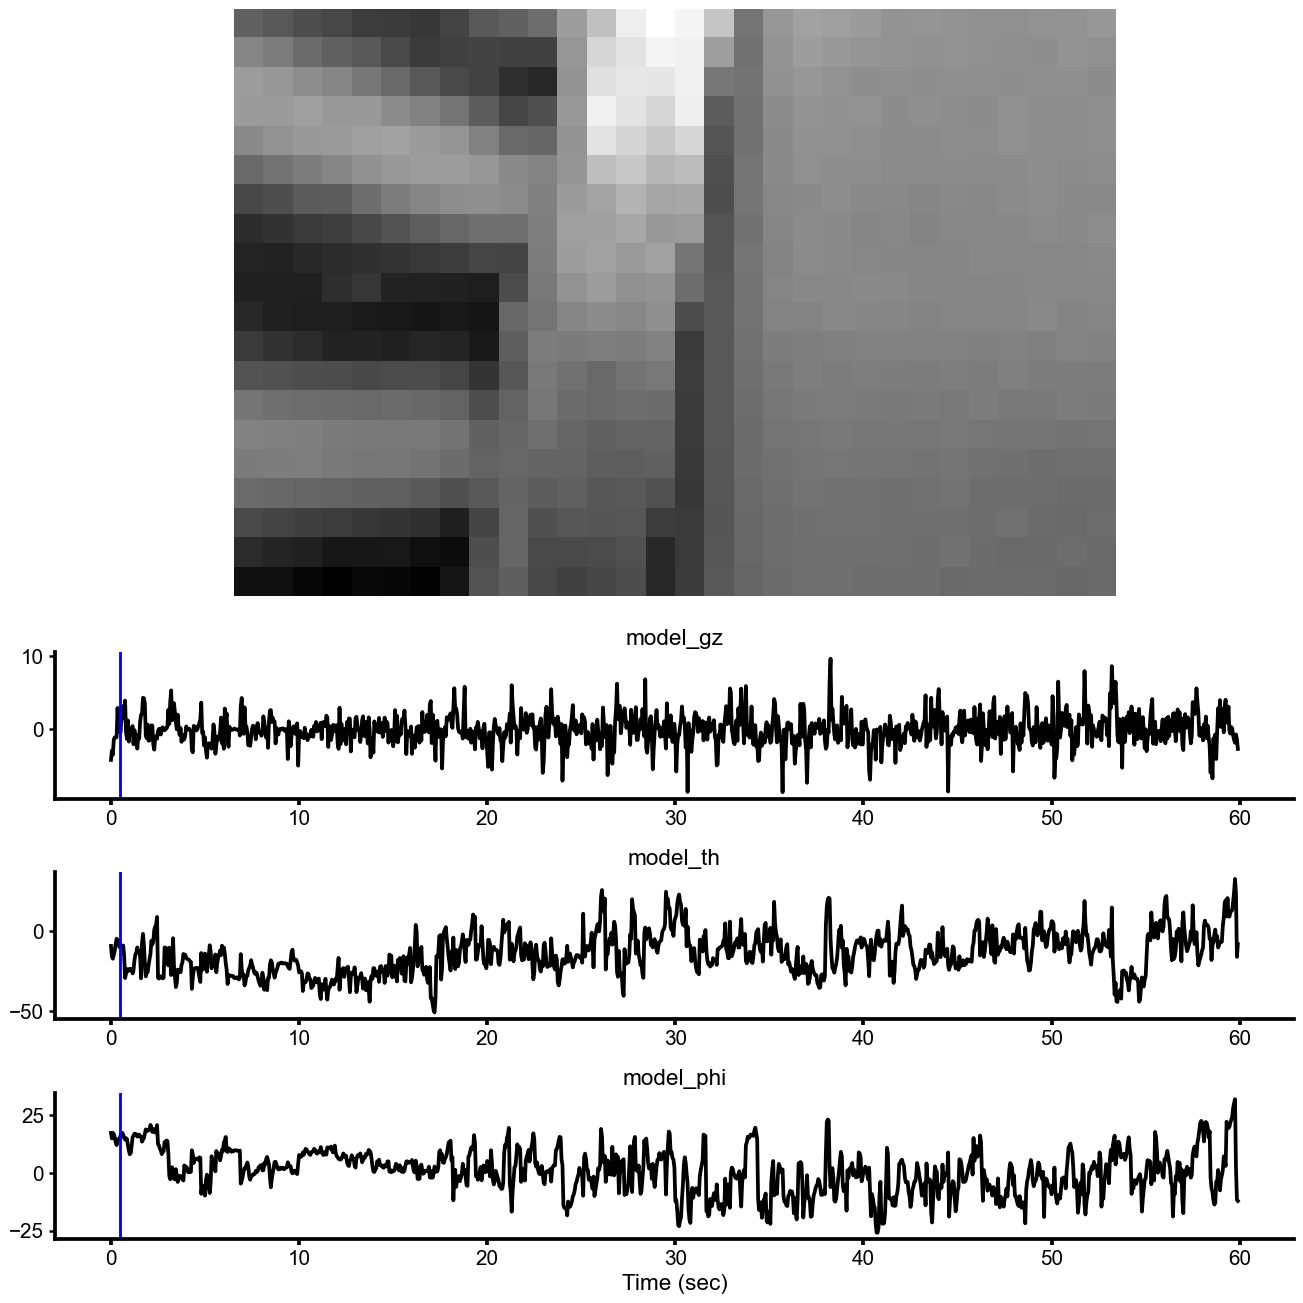

In [6]:
t = 10
time_range = np.arange(0,int(60//model_dt))

fig2 = plt.figure(constrained_layout=False, figsize=(15, 15),dpi=90)
spec2 = gridspec.GridSpec(ncols=2, nrows=4, figure=fig2)
axs1 = fig2.add_subplot(spec2[:2, :])
inner_grid = gridspec.GridSpecFromSubplotSpec(3, 1, spec2[2:, :],hspace=.5)
axs2a = fig2.add_subplot(inner_grid[0, 0])
axs2b = fig2.add_subplot(inner_grid[1, 0])
axs2c = fig2.add_subplot(inner_grid[2, 0])
width, height = fig2.get_size_inches() * fig2.get_dpi()
# Image frame 
axs1.imshow(model_vid_sm[t], cmap='gray')
axs1.axis('off')

# Movement Params
axs2a.plot(time_range*model_dt,model_gz[time_range],'k',lw=3)
axs2a.axvline(x=t*model_dt,c='b')
axs2a.set_title('Gyro z')
# axs2a.set_xlabel('Time (sec)')
axs2b.plot(time_range*model_dt,model_th[time_range], 'k', lw=3)
axs2b.axvline(x=t*model_dt,c='b')
axs2b.set_title('Eye Theta')
# axs2b.set_xlabel('Time (sec)')
axs2c.plot(time_range*model_dt,model_phi[time_range], 'k', lw=3)
axs2c.axvline(x=t*model_dt,c='b')
axs2c.set_title('Eye Phi')
axs2c.set_xlabel('Time (sec)')
plt.tight_layout()
fig2.canvas.draw()       # draw the canvas, cache the renderer
images = np.frombuffer(fig2.canvas.tostring_rgb(), dtype='uint8').reshape(int(height), int(width), 3)


In [8]:
@ray.remote
def make_plt_im(t, time_range, model_vid_sm, model_gz, model_th, model_phi, pbar: ActorHandle,):  #
    fig2 = plt.figure(constrained_layout=False, figsize=(15, 15), dpi=90)
    spec2 = gridspec.GridSpec(ncols=2, nrows=4, figure=fig2)
    axs1 = fig2.add_subplot(spec2[:2, :])
    inner_grid = gridspec.GridSpecFromSubplotSpec(3, 1, spec2[2:, :], hspace=.5)
    axs2a = fig2.add_subplot(inner_grid[0, 0])
    axs2b = fig2.add_subplot(inner_grid[1, 0])
    axs2c = fig2.add_subplot(inner_grid[2, 0])
    # Image frame
    axs1.imshow(model_vid_sm[t], cmap='gray')
    axs1.axis('off')

    # Movement Params
    axs2a.plot(time_range*model_dt, model_gz[time_range], 'k', lw=3)
    axs2a.axvline(x=t*model_dt, c='b')
    axs2a.set_title('Gyro z')
    axs2b.plot(time_range*model_dt, model_th[time_range], 'k', lw=3)
    axs2b.axvline(x=t*model_dt, c='b')
    axs2b.set_title('Eye Theta')
    axs2c.plot(time_range*model_dt, model_phi[time_range], 'k', lw=3)
    axs2c.axvline(x=t*model_dt, c='b')
    axs2c.set_title('Eye Phi')
    axs2c.set_xlabel('Time (sec)')
    plt.tight_layout()

    width, height = fig2.get_size_inches() * fig2.get_dpi()
    fig2.canvas.draw()       # draw the canvas, cache the renderer
    images = np.frombuffer(fig2.canvas.tostring_rgb(),
                        dtype='uint8').reshape(int(height), int(width), 3)
    
    plt.close()
    pbar.update.remote(1)
    return images


In [9]:
mpl.use('agg')

start = time.time()
##### initialize time points for animation and progressbar #####
t = 0
time_range = np.arange(t,t+int(60//model_dt))
num_ticks = np.size(time_range)
pb = ProgressBar(num_ticks)
actor = pb.actor

##### Put large arrays into shared memory #####
time_range_r = ray.put(time_range)
model_vid_sm_r = ray.put(model_vid_sm)
model_gz_r = ray.put(model_gz)
model_th_r = ray.put(model_th)
model_phi_r = ray.put(model_phi)


##### Loop over parameters appending process ids #####
result_ids = []
for t in time_range:
    result_ids.append(make_plt_im.remote(t, time_range_r, model_vid_sm_r, model_gz_r, model_th_r, model_phi_r, actor))

##### pring progressbar and get results #####
pb.print_until_done()
results_p = ray.get(result_ids)
images = np.stack([results_p[i] for i in range(len(results_p))])

##### Make video with opencv #####
aniname = file_dict['name'] + '_summary.mp4'
vid_name = FigPath / aniname
FPS = int(1/model_dt)
out = cv2.VideoWriter(vid_name.as_posix(), cv2.VideoWriter_fourcc(*'mp4v'), FPS, (images.shape[-2], images.shape[-3]))

for fm in range(images.shape[0]):
    out.write(cv2.cvtColor(images[fm], cv2.COLOR_BGR2RGB))
out.release()
print('Making Animation {}: {}'.format(aniname, time.time()-start))
del results_p, time_range_r, model_vid_sm_r, model_gz_r, model_th_r, model_phi_r, pb
gc.collect()


  0%|          | 0/1199 [00:00<?, ?it/s]

Making Animation 070921_J553RT_control_Rig2_fm1_summary.mp4: 47.20698881149292


21